In [1]:
# ============================================================
# 2_Baseline_Comparison.ipynb – Raw Performance (with QWK)
# Baseline modeling on *raw processed* data
# ============================================================

import os
import gc
import json
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    cohen_kappa_score,
    accuracy_score,
    f1_score,
    confusion_matrix
)

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")
sns.set_context("talk")

RANDOM_STATE = 42
N_SPLITS = 5
DATA_VERSION = "raw_processed"  # used in filenames
OUTPUT_DIR = Path("./oof_predictions")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print("Config OK")


Config OK


In [2]:
# ============================================================
# Target column detection
# ============================================================

def infer_target_column(df, candidates=None, verbose=True):
    """
    Try to infer the target column.
    1) Prefer well-known names.
    2) Fallback heuristic: low-cardinality int column.
    """
    if candidates is None:
        candidates = ["target", "sii", "label", "class", "y"]
        
    # 1) Check common names
    for c in candidates:
        if c in df.columns:
            if verbose:
                print(f"[Target Detection] Using column '{c}' as target.")
            return c
    
    # 2) Heuristic: integer column with small number of unique values
    best_col = None
    best_unique = None
    for col in df.columns:
        series = df[col]
        if pd.api.types.is_integer_dtype(series) or pd.api.types.is_bool_dtype(series):
            nunique = series.nunique()
            if 1 < nunique <= 10:
                if (best_unique is None) or (nunique < best_unique):
                    best_col = col
                    best_unique = nunique
    
    if best_col is not None:
        if verbose:
            print(f"[Target Detection] Heuristic target: '{best_col}' "
                  f"(unique classes = {best_unique}).")
        return best_col
    
    raise ValueError(
        "Could not infer target column. "
        "Please rename your target to one of: "
        f"{', '.join(candidates)}"
    )

print("Target detection helper ready.")


Target detection helper ready.


In [3]:
# ============================================================
# Metrics: Quadratic Weighted Kappa + others
# ============================================================

def qwk(y_true, y_pred):
    """Quadratic weighted kappa using sklearn's cohen_kappa_score."""
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")


def compute_metrics(y_true, y_pred):
    """Return dict of all required metrics."""
    return {
        "QWK": qwk(y_true, y_pred),
        "Accuracy": accuracy_score(y_true, y_pred),
        "MacroF1": f1_score(y_true, y_pred, average="macro"),
        "Kappa": cohen_kappa_score(y_true, y_pred)
    }


# ============================================================
# Class imbalance handling
# ============================================================

def compute_class_weights(y):
    """
    Simple inverse-frequency class weights:
    w_c = N / (n_classes * count_c)
    """
    y = np.asarray(y)
    values, counts = np.unique(y, return_counts=True)
    n_samples = len(y)
    n_classes = len(values)
    weights = {}
    for cls, cnt in zip(values, counts):
        weights[cls] = n_samples / (n_classes * cnt)
    return weights


def make_sample_weights(y, class_weights):
    return np.array([class_weights[cls] for cls in y])

print("Metrics + imbalance helpers ready.")


Metrics + imbalance helpers ready.


In [ ]:
# ============================================================
# Cross-validation training (generic for LGBM / XGB / CatBoost)
# ============================================================

def train_cv_model(
    model_name,
    base_model_cls,
    base_params,
    X,
    y,
    X_test,
    n_splits=5,
    random_state=42,
    model_suffix="",
):
    """
    Generic K-Fold training with:
      - StratifiedKFold
      - QWK + Accuracy + MacroF1 + Kappa
      - OOF & test preds (probabilities)
      - Class imbalance via sample weights
    """
    print(f"\n{'='*60}")
    print(f"Training {model_name} [{DATA_VERSION}]")
    print(f"{'='*60}")
    
    oof_pred_proba = np.zeros((len(X), len(np.unique(y))), dtype=float)
    test_pred_proba = np.zeros((len(X_test), len(np.unique(y))), dtype=float)
    
    folds = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )
    
    class_weights = compute_class_weights(y)
    print("Class weights:", class_weights)
    
    fold_metrics = []
    
    for fold, (trn_idx, val_idx) in enumerate(folds.split(X, y), 1):
        print(f"\n--- Fold {fold}/{n_splits} ---")
        X_trn, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_trn, y_val = y[trn_idx], y[val_idx]
        
        sample_weight = make_sample_weights(y_trn, class_weights)
        
        # fresh model
        if model_name.lower().startswith("cat"):
            # CatBoost needs parameters passed to constructor
            model = base_model_cls(**base_params)
            model.fit(
                X_trn,
                y_trn,
                sample_weight=sample_weight,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
        else:
            model = base_model_cls(**base_params)
            model.fit(
                X_trn,
                y_trn,
                sample_weight=sample_weight,
                eval_set=[(X_val, y_val)],
                eval_metric="mlogloss" if model_name.lower().startswith("xgb") else None,
                verbose=False
            )
        
        # validation predictions
        val_proba = model.predict_proba(X_val)
        val_pred = val_proba.argmax(axis=1)
        
        oof_pred_proba[val_idx] = val_proba
        
        # test predictions
        test_proba = model.predict_proba(X_test)
        test_pred_proba += test_proba / n_splits
        
        # metrics
        m = compute_metrics(y_val, val_pred)
        fold_metrics.append(m)
        print(f"Fold {fold} metrics:")
        for k, v in m.items():
            print(f"  {k}: {v:.4f}")
    
    # aggregate metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()
    
    print("\nCV metrics (mean ± std):")
    for m_name in ["QWK", "Accuracy", "MacroF1", "Kappa"]:
        print(f"  {m_name}: {mean_metrics[m_name]:.4f} ± {std_metrics[m_name]:.4f}")
    
    # best single fold in terms of QWK
    best_fold_idx = metrics_df["QWK"].idxmax()
    best_fold_score = metrics_df.loc[best_fold_idx, "QWK"]
    
    results = {
        "model_name": model_name,
        "metrics_df": metrics_df,
        "cv_mean": mean_metrics,
        "cv_std": std_metrics,
        "best_fold_qwk": best_fold_score,
        "oof_pred_proba": oof_pred_proba,
        "test_pred_proba": test_pred_proba
    }
    return results


In [11]:
# ============================================================
# Confusion matrix helper (OOF-based)
# ============================================================

def plot_confusion_matrix(y_true, oof_pred_proba, class_names=None, normalize=True):
    """
    Colorblind-friendly confusion matrix based on OOF predictions.
    """
    y_pred = oof_pred_proba.argmax(axis=1)
    
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    
    if class_names is None:
        classes = np.unique(y_true)
        class_names = [str(c) for c in classes]
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f" if normalize else "d",
        cmap="viridis",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("OOF Confusion Matrix")
    plt.tight_layout()
    plt.show()


In [12]:
# ============================================================
# Load raw processed data
# ============================================================

TRAIN_PATH = Path("./train_processed.csv")
TEST_PATH = Path("./test_processed.csv")

assert TRAIN_PATH.exists(), f"{TRAIN_PATH} not found. Please upload it."
assert TEST_PATH.exists(), f"{TEST_PATH} not found. Please upload it."

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()


Train shape: (2736, 181)
Test shape: (20, 158)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,quarter_75%,quarter_max,relative_date_PCIAT_count,relative_date_PCIAT_mean,relative_date_PCIAT_std,relative_date_PCIAT_min,relative_date_PCIAT_25%,relative_date_PCIAT_50%,relative_date_PCIAT_75%,relative_date_PCIAT_max
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,3.0,43330.0,53.201683,14.244915,41.0,42.0,50.0,53.0,85.0
4,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,...,3.0,3.0,396396.0,79.435593,6.634319,68.0,74.0,79.0,85.0,91.0


In [16]:
# ============================================================
# Identify target, label-encode, prepare X/y
# ============================================================

target_col = infer_target_column(train)

# Drop obvious ID columns if present (doesn't change feature values)
ID_CANDIDATES = ["id", "ID", "Id", "subject_id", "record_id"]
id_cols = [c for c in ID_CANDIDATES if c in train.columns]

if id_cols:
    print("Dropping ID columns:", id_cols)

# 1) Start from all non-ID, non-target columns
feature_cols = [c for c in train.columns if c not in (id_cols + [target_col])]

# 2) EXCLUDE '-Season' and '_Season' columns (your request)
season_cols = [c for c in feature_cols if c.endswith("-Season") or c.endswith("_Season")]
if season_cols:
    print("\nDropping Season columns (string/object):")
    for col in season_cols:
        print(f"   - {col}")
    feature_cols = [c for c in feature_cols if c not in season_cols]

# 3) Ensure all remaining feature_cols exist in TEST (handles PCIAT issue)
missing_in_test = [c for c in feature_cols if c not in test.columns]
if missing_in_test:
    print("\n⚠️ Columns present in TRAIN but missing in TEST – will be dropped:")
    for col in missing_in_test:
        print(f"   - {col}")
    feature_cols = [c for c in feature_cols if c in test.columns]

# 4) Final matrices
X = train[feature_cols].copy()
X_test = test[feature_cols].copy()

y_raw = train[target_col].copy()

# Label encode target
le_target = LabelEncoder()
y = le_target.fit_transform(y_raw)
class_names = [str(c) for c in le_target.classes_]

n_classes = len(le_target.classes_)
print(f"\nDetected {n_classes} classes:", class_names)
print("Final feature count:", len(feature_cols))

# Show class distribution
cls_counts = pd.Series(y).value_counts().sort_index()
cls_dist = (cls_counts / len(y)).rename("freq")
display(pd.concat([cls_counts.rename("count"), cls_dist], axis=1))


[Target Detection] Using column 'sii' as target.
Dropping ID columns: ['id']

Dropping Season columns (string/object):
   - Basic_Demos-Enroll_Season
   - CGAS-Season
   - Physical-Season
   - Fitness_Endurance-Season
   - FGC-Season
   - BIA-Season
   - PAQ_A-Season
   - PAQ_C-Season
   - PCIAT-Season
   - SDS-Season
   - PreInt_EduHx-Season

⚠️ Columns present in TRAIN but missing in TEST – will be dropped:
   - PCIAT-PCIAT_01
   - PCIAT-PCIAT_02
   - PCIAT-PCIAT_03
   - PCIAT-PCIAT_04
   - PCIAT-PCIAT_05
   - PCIAT-PCIAT_06
   - PCIAT-PCIAT_07
   - PCIAT-PCIAT_08
   - PCIAT-PCIAT_09
   - PCIAT-PCIAT_10
   - PCIAT-PCIAT_11
   - PCIAT-PCIAT_12
   - PCIAT-PCIAT_13
   - PCIAT-PCIAT_14
   - PCIAT-PCIAT_15
   - PCIAT-PCIAT_16
   - PCIAT-PCIAT_17
   - PCIAT-PCIAT_18
   - PCIAT-PCIAT_19
   - PCIAT-PCIAT_20
   - PCIAT-PCIAT_Total

Detected 4 classes: ['0', '1', '2', '3']
Final feature count: 147


,count,freq
0,1594,0.582602
1,730,0.266813
2,378,0.138158
3,34,0.012427



Training LGBM [raw_processed]
Class weights: {np.int64(0): np.float64(0.42910915934755334), np.int64(1): np.float64(0.936986301369863), np.int64(2): np.float64(1.8095238095238095), np.int64(3): np.float64(20.11764705882353)}

--- Fold 1/5 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24345
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 147
[LightGBM] [Info] Start training from score -1.384241
[LightGBM] [Info] Start training from score -1.384084
[LightGBM] [Info] Start training from score -1.385407
[LightGBM] [Info] Start training from score -1.391464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

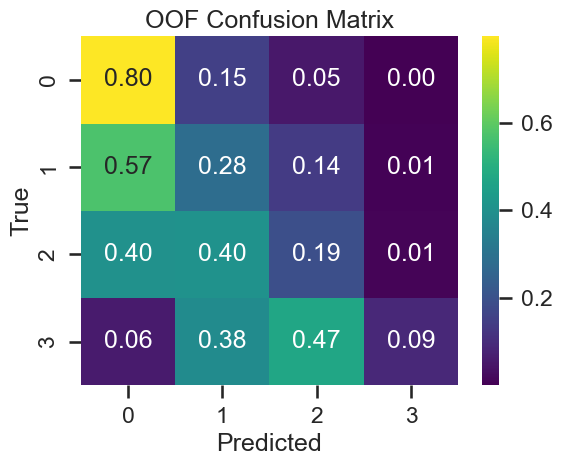

In [17]:
# ============================================================
# LightGBM baseline on raw processed data
# ============================================================

lgb_params = dict(
    objective="multiclass",
    num_class=n_classes,
    n_estimators=400,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

lgb_results_raw = train_cv_model(
    model_name="LGBM",
    base_model_cls=LGBMClassifier,
    base_params=lgb_params,
    X=X,
    y=y,
    X_test=X_test,
    n_splits=N_SPLITS,
    random_state=RANDOM_STATE
)

# Confusion matrix
plot_confusion_matrix(
    y_true=y,
    oof_pred_proba=lgb_results_raw["oof_pred_proba"],
    class_names=class_names,
    normalize=True
)



Training XGB [raw_processed]
Class weights: {np.int64(0): np.float64(0.42910915934755334), np.int64(1): np.float64(0.936986301369863), np.int64(2): np.float64(1.8095238095238095), np.int64(3): np.float64(20.11764705882353)}

--- Fold 1/5 ---
Fold 1 metrics:
  QWK: 0.3893
  Accuracy: 0.5675
  MacroF1: 0.3920
  Kappa: 0.2217

--- Fold 2/5 ---
Fold 2 metrics:
  QWK: 0.4115
  Accuracy: 0.6015
  MacroF1: 0.3549
  Kappa: 0.2494

--- Fold 3/5 ---
Fold 3 metrics:
  QWK: 0.3729
  Accuracy: 0.5850
  MacroF1: 0.4148
  Kappa: 0.2476

--- Fold 4/5 ---
Fold 4 metrics:
  QWK: 0.2956
  Accuracy: 0.5612
  MacroF1: 0.3533
  Kappa: 0.1816

--- Fold 5/5 ---
Fold 5 metrics:
  QWK: 0.4057
  Accuracy: 0.5850
  MacroF1: 0.3816
  Kappa: 0.2399

CV metrics (mean ± std):
  QWK: 0.3750 ± 0.0469
  Accuracy: 0.5800 ± 0.0160
  MacroF1: 0.3793 ± 0.0260
  Kappa: 0.2281 ± 0.0282


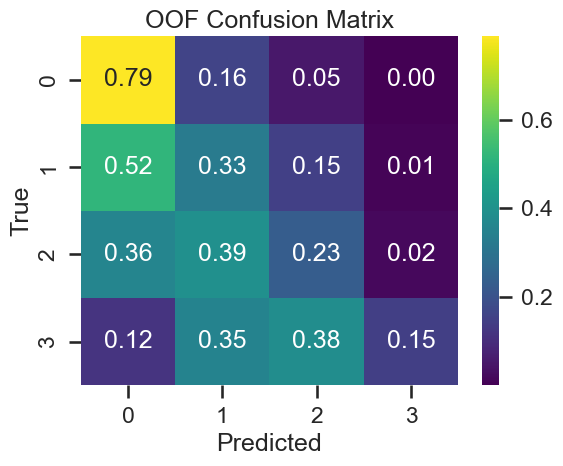

In [18]:
# ============================================================
# XGBoost baseline on raw processed data
# ============================================================

xgb_params = dict(
    objective="multi:softprob",
    num_class=n_classes,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb_results_raw = train_cv_model(
    model_name="XGB",
    base_model_cls=XGBClassifier,
    base_params=xgb_params,
    X=X,
    y=y,
    X_test=X_test,
    n_splits=N_SPLITS,
    random_state=RANDOM_STATE
)

plot_confusion_matrix(
    y_true=y,
    oof_pred_proba=xgb_results_raw["oof_pred_proba"],
    class_names=class_names,
    normalize=True
)



Training CatBoost [raw_processed]
Class weights: {np.int64(0): np.float64(0.42910915934755334), np.int64(1): np.float64(0.936986301369863), np.int64(2): np.float64(1.8095238095238095), np.int64(3): np.float64(20.11764705882353)}

--- Fold 1/5 ---
Fold 1 metrics:
  QWK: 0.4452
  Accuracy: 0.5511
  MacroF1: 0.4321
  Kappa: 0.2560

--- Fold 2/5 ---
Fold 2 metrics:
  QWK: 0.4648
  Accuracy: 0.5868
  MacroF1: 0.4448
  Kappa: 0.2898

--- Fold 3/5 ---
Fold 3 metrics:
  QWK: 0.4217
  Accuracy: 0.5430
  MacroF1: 0.4199
  Kappa: 0.2678

--- Fold 4/5 ---
Fold 4 metrics:
  QWK: 0.3654
  Accuracy: 0.5430
  MacroF1: 0.3841
  Kappa: 0.2437

--- Fold 5/5 ---
Fold 5 metrics:
  QWK: 0.3845
  Accuracy: 0.5484
  MacroF1: 0.3833
  Kappa: 0.2249

CV metrics (mean ± std):
  QWK: 0.4163 ± 0.0413
  Accuracy: 0.5545 ± 0.0184
  MacroF1: 0.4129 ± 0.0280
  Kappa: 0.2565 ± 0.0245


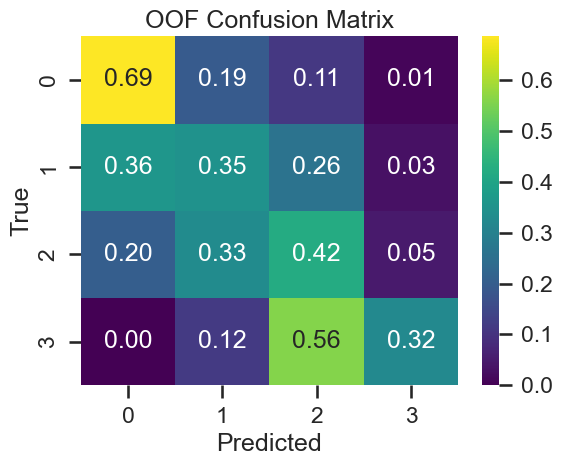

In [19]:
# ============================================================
# CatBoost baseline on raw processed data
# ============================================================

cat_params = dict(
    loss_function="MultiClass",
    eval_metric="TotalF1:average=Macro",
    depth=6,
    learning_rate=0.05,
    n_estimators=600,
    random_state=RANDOM_STATE,
    thread_count=-1,
    verbose=False
)

cat_results_raw = train_cv_model(
    model_name="CatBoost",
    base_model_cls=CatBoostClassifier,
    base_params=cat_params,
    X=X,
    y=y,
    X_test=X_test,
    n_splits=N_SPLITS,
    random_state=RANDOM_STATE
)

plot_confusion_matrix(
    y_true=y,
    oof_pred_proba=cat_results_raw["oof_pred_proba"],
    class_names=class_names,
    normalize=True
)


In [20]:
# ============================================================
# Save OOF & test predictions for later ensembling
# ============================================================

def save_preds(results, model_key):
    # OOF
    oof_df = pd.DataFrame(
        results["oof_pred_proba"],
        columns=[f"proba_{cls}" for cls in class_names]
    )
    oof_df[target_col] = y_raw.values
    if id_cols:
        oof_df[id_cols[0]] = train[id_cols[0]].values  # keep one ID if present
    
    oof_path = OUTPUT_DIR / f"oof_{DATA_VERSION}_{model_key}.csv"
    oof_df.to_csv(oof_path, index=False)
    
    # Test
    test_df = pd.DataFrame(
        results["test_pred_proba"],
        columns=[f"proba_{cls}" for cls in class_names]
    )
    if id_cols:
        test_df[id_cols[0]] = test[id_cols[0]].values
    
    test_path = OUTPUT_DIR / f"test_{DATA_VERSION}_{model_key}.csv"
    test_df.to_csv(test_path, index=False)
    
    print(f"Saved: {oof_path}")
    print(f"Saved: {test_path}")
    

save_preds(lgb_results_raw, "lgbm")
save_preds(xgb_results_raw, "xgb")
save_preds(cat_results_raw, "cat")


Saved: oof_predictions\oof_raw_processed_lgbm.csv
Saved: oof_predictions\test_raw_processed_lgbm.csv
Saved: oof_predictions\oof_raw_processed_xgb.csv
Saved: oof_predictions\test_raw_processed_xgb.csv
Saved: oof_predictions\oof_raw_processed_cat.csv
Saved: oof_predictions\test_raw_processed_cat.csv


In [21]:
# ============================================================
# Raw processed summary table (per model)
# ============================================================

def summarize_model_results(model_name, res):
    mean = res["cv_mean"]
    std = res["cv_std"]
    return {
        "Data Version": "Raw processed",
        "Model": model_name,
        "CV QWK (mean)": mean["QWK"],
        "CV QWK (std)": std["QWK"],
        "Accuracy": mean["Accuracy"],
        "Macro F1": mean["MacroF1"],
        "Kappa": mean["Kappa"],
        "Best Single Fold": res["best_fold_qwk"],
        "LB Estimate": np.nan  # will fill in final notebook if desired
    }

rows = []
rows.append(summarize_model_results("LGBM", lgb_results_raw))
rows.append(summarize_model_results("XGB", xgb_results_raw))
rows.append(summarize_model_results("CatBoost", cat_results_raw))

raw_summary_df = pd.DataFrame(rows)
display(raw_summary_df)

# Save for final comparison in 8_Final_Modeling notebook
raw_summary_path = OUTPUT_DIR / "summary_raw_processed.csv"
raw_summary_df.to_csv(raw_summary_path, index=False)
print("Saved raw summary to:", raw_summary_path)


,Data Version,Model,CV QWK (mean),CV QWK (std),Accuracy,Macro F1,Kappa,Best Single Fold,LB Estimate
0,Raw processed,LGBM,0.339931,0.038732,0.567261,0.347359,0.190363,0.388147,NaN
1,Raw processed,XGB,0.375030,0.046888,0.580048,0.379318,0.228054,0.411513,NaN
2,Raw processed,CatBoost,0.416341,0.041267,0.554460,0.412852,0.256454,0.464778,NaN


Saved raw summary to: oof_predictions\summary_raw_processed.csv
